In [221]:
import pandas 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, r2_score

In [188]:
data = pandas.read_csv('ExtractedTweets.csv')

In [189]:
data.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


## Part 1 : Data Cleaning 

 We will now remove all extra characters, usernames, URLS and lemmatize the words. 

In [190]:
stop = stopwords.words("english")
data['Tweet']=data['Tweet'].apply(lambda x:' '.join([word for word in x.split()if word not in (stop)]))

In [191]:
def remove_user(input_txt,pattern):
    r = re.findall(pattern, input_txt)
    for i in r: 
        input_txt = re.sub(i,'',input_txt)
        
    return input_txt

In [192]:
data['Tweet']= np.vectorize(remove_user)(data['Tweet'], "@[\w]*")
data['Tweet'] = data['Tweet'].str.replace("[^a-zA-Z#]", " ")
data['Tweet'] = data['Tweet'].str.lower()
data['Tweet'] = data['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data['Tweet'] = data['Tweet'].str.replace(r"http\S+", "")

Here we assign binary values to the values for 'Democrat' and 'Republican'

In [193]:
data['Party'] = data['Party'].str.replace("Democrat", "1")
data['Party'] = data['Party'].str.replace("Republican", "0")

In [194]:
data.head()

,Party,Handle,Tweet
0,1,RepDarrenSoto,today senate dems vote #savetheinternet proud ...
1,1,RepDarrenSoto,winter haven resident alta vista teacher sever...
2,1,RepDarrenSoto,noted hurricane maria left approximately billi...
3,1,RepDarrenSoto,meeting thanks taking time meet marucci guzman...
4,1,RepDarrenSoto,hurricane season starts june puerto rico readi...


Here we lemmatize the words in the Tweet column

In [195]:
lemmatize = WordNetLemmatizer()
data['Tweet'] = data['Tweet'].apply(lambda x: ' '.join([lemmatize.lemmatize(word,'v')for word in x.split()]))

### Understanding the structure of our data

In [196]:
democrat = data[data['Party']=='1']
republican = data[data['Party']=='0']

In [197]:
data.shape

(86460, 3)

In [198]:
democrat.shape

(42068, 3)

In [199]:
republican.shape

(44392, 3)

In [200]:
print(democrat.groupby('Handle').nunique())

                 Party  Handle  Tweet
Handle                               
AGBecerra            1       1    200
AlanGrayson          1       1    199
AnthonyBrownMD4      1       1    199
BennieGThompson      1       1    199
BettyMcCollum04      1       1    200
...                ...     ...    ...
repjohnlewis         1       1    200
repmarkpocan         1       1    200
repsandylevin        1       1    200
rosadelauro          1       1    200
sethmoulton          1       1    200

[211 rows x 3 columns]


In [201]:
print(republican.groupby('Handle').nunique())

                 Party  Handle  Tweet
Handle                               
AustinScottGA08      1       1    200
ConawayTX11          1       1    200
CongCulberson        1       1    199
CongMikeSimpson      1       1    199
CongressmanDan       1       1    200
...                ...     ...    ...
repdonyoung          1       1    200
repgregwalden        1       1    200
replouiegohmert      1       1    199
reppittenger         1       1    200
virginiafoxx         1       1    199

[222 rows x 3 columns]


## Part 2 : Data Visualization
In this section we will visualize the most commonly used words in the set and attempt to gain a better understanding of our data! 

First we want to extract all hashtags to visualize their use

In [202]:
hashtags = []
pattern = re.compile(r"#[a-zA-Z]+")
matches = list(data['Tweet'].apply(pattern.findall))

In [203]:
tag_dict = {}
for match in matches:
    for single in match:
        if single not in tag_dict.keys():
            tag_dict[single] = 1
        else:
            tag_dict[single] = tag_dict[single]+1

In [204]:
tag_ordered_list =sorted(tag_dict.items(), key=lambda x:x[1])
tag_ordered_list = tag_ordered_list[::-1]
ordered_values = []
ordered_keys = []
for item in tag_ordered_list[0:50]:
    ordered_keys.append(item[0])
    ordered_values.append(item[1])

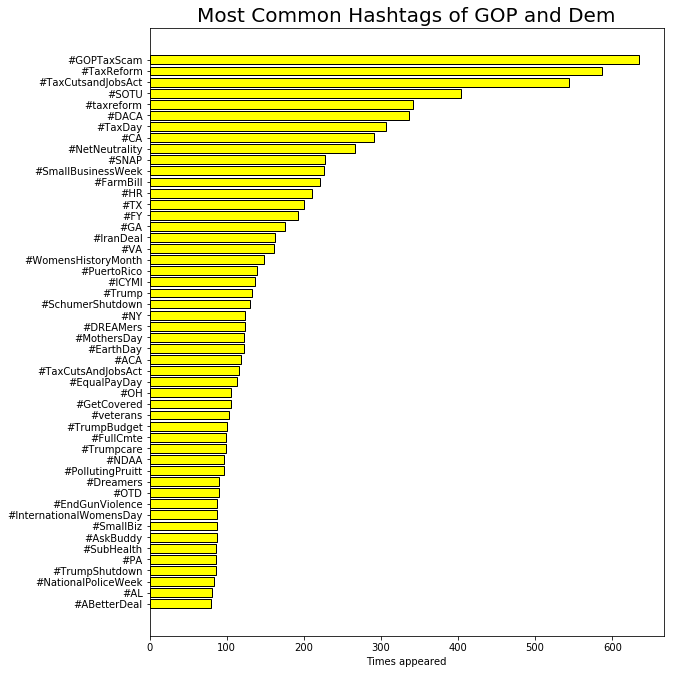

In [205]:
fig, ax = plt.subplots(figsize = (10,10))
y_pos = np.arange(len(hashtag_ordered_keys))
ax.barh(y_pos ,list(hashtag_ordered_values)[::-1], align='center', color = 'Yellow', edgecolor = 'black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
ax.set_xlabel("Times appeared")
ax.set_title("Most Common Hashtags of GOP and Dem", fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

Now we are going to use WordCloud to Visualize the frequency of words in General, Democratic, and Republican categories

<function matplotlib.pyplot.show(*args, **kw)>

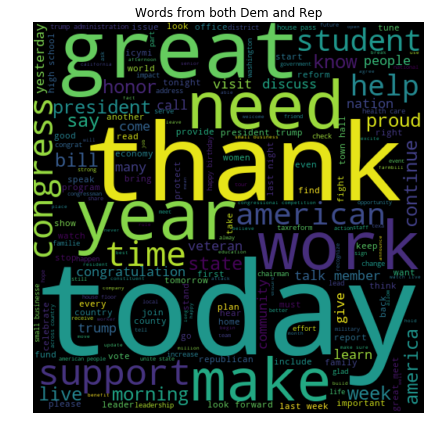

In [206]:
general = ' '.join([i for i in data['Tweet']]) 
wordcloud = WordCloud(width=500,height=500,random_state=40,max_font_size=200).generate(general)

plt.figure(figsize=(7,9))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title('Words from both Dem and Rep')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

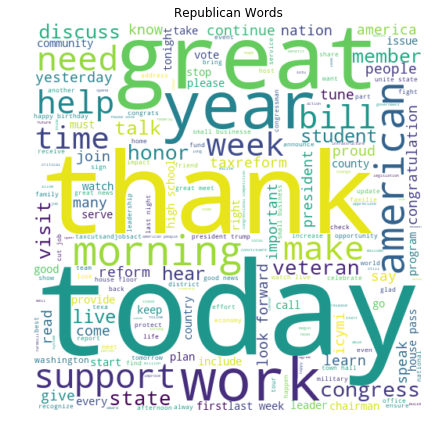

In [207]:
republican_cloud = ' '.join([i for i in republican['Tweet']]) 
wordcloud = WordCloud(background_color='white',width=500,height=500,random_state=40,max_font_size=200).generate(republican_cloud)

plt.figure(figsize=(7,9))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title('Republican Words')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

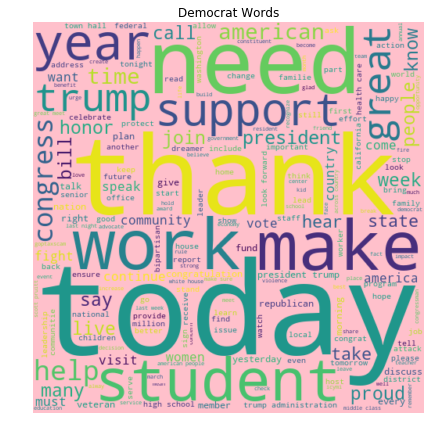

In [208]:
democrat_cloud = ' '.join([i for i in democrat['Tweet']]) 
wordcloud = WordCloud(background_color='pink',width=500,height=500,random_state=40,max_font_size=200).generate(democrat_cloud)

plt.figure(figsize=(7,9))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title('Democrat Words')
plt.show

## Part 3: Creating a Pipeline and Fitting a Model !
 - In this section using Count Vectorizer and TF-IDF in a pipeline we will create a Naive Bayes Classifier, Decision Tree Regressor, and a SVM or Support Vector Machine

- Count-Vectorizer is a process in which the term frequency of a document is recorded in the form of a vector. 

- TFIDF uses Count Vectorizer to then generate scores for relative term frequency of a document. It is essentially a weight that determines how important or valuable a particular word is to a document. 

Here we created stratified train and test sets so that the proportion of democratic and republican tweets are represented accuratley

In [209]:
data2 = data.copy()
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=12)
for train_index, test_index in split.split(data2, data2['Party']):
     train = data2.loc[train_index]
     test = data2.loc[test_index]

In [210]:
train.head()

,Party,Handle,Tweet
63427,0,SamsPressShop,need sure state local employees right amount t...
45650,0,HouseSmallBiz,#taxday hear directly state #taxcutsandjobsact...
18639,1,RepJohnYarmuth,barbara bush woman surround usually always ass...
57956,0,RepLukeMesser,like every american deeply sadden tragedy park...
21776,1,RepAnnaEshoo,trump administration cruel action medicaid tod...


In [211]:
y = train['Party']
X = train['Tweet']
test_tweet = test['Tweet']
test_ans = test['Party']

### Multinomial Naive Bayes Classifier

In [212]:
NBpipeline = Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier', MultinomialNB()),
])
NBpipeline.fit(X,y)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [215]:
predicted_test = NBpipeline.predict(test_tweet)
print("NB Validation Data Accuracy Score: ",accuracy_score(test_ans, predicted_test))
print("NB Confusion Matrix : ", confusion_matrix(test_ans, predicted_test))
print("NB Classification Report: ",classification_report(test_ans,predicted_test))

NB Validation Data Accuracy Score:  0.7541059449456397
NB Confusion Matrix :  [[7253 1625]
 [2627 5787]]
NB Classification Report:                precision    recall  f1-score   support

           0       0.73      0.82      0.77      8878
           1       0.78      0.69      0.73      8414

    accuracy                           0.75     17292
   macro avg       0.76      0.75      0.75     17292
weighted avg       0.76      0.75      0.75     17292



### Decision Tree Regressor

In [222]:
DTRpipeline = Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('clf', DecisionTreeClassifier()),
])
DTRpipeline.fit(X,y)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                            

In [225]:
DTR_test = DTRpipeline.predict(test_tweet)
print("DTR Test Data Accuracy Score: ",accuracy_score(test_ans, DTR_test))
print("DTR Confusion Matrix : ", confusion_matrix(test_ans, DTR_test))
print("DTR Classification Report: ",classification_report(test_ans,DTR_test))

DTR Validation Data Accuracy Score:  0.6516886421466574
DTR Confusion Matrix :  [[6026 2852]
 [3171 5243]]
DTR Classification Report:                precision    recall  f1-score   support

           0       0.66      0.68      0.67      8878
           1       0.65      0.62      0.64      8414

    accuracy                           0.65     17292
   macro avg       0.65      0.65      0.65     17292
weighted avg       0.65      0.65      0.65     17292



### Support Vector Machine (SVM)

In [229]:
SVMpipeline = Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier', SVC(kernel='linear',gamma=0.1)),
])
SVMpipeline.fit(X,y)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.1,


In [230]:
SVM_test = SVMpipeline.predict(test_tweet)
print("SVM Test Data Accuracy Score: ",accuracy_score(test_ans, SVM_test))
print("SVM Confusion Matrix : ", confusion_matrix(test_ans, SVM_test))
print("SVM Classification Report: ",classification_report(test_ans,SVM_test))

SVM Test Data Accuracy Score:  0.7520240573675688
SVM Confusion Matrix :  [[6903 1975]
 [2313 6101]]
SVM Classification Report:                precision    recall  f1-score   support

           0       0.75      0.78      0.76      8878
           1       0.76      0.73      0.74      8414

    accuracy                           0.75     17292
   macro avg       0.75      0.75      0.75     17292
weighted avg       0.75      0.75      0.75     17292

